In [1]:
# GENERATE BUY SELL SIGNALS

## Library Import & Data Import

In [3]:
import quandl
import yfinance as yf
from yahoofinancials import YahooFinancials

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pandas_datareader as pdr

In [3]:
ticker=input('Ticker: ')

amzn = pdr.get_data_yahoo(ticker, start="2017-01-01", end="2020-03-06")
amzn.drop(['High','Low','Open','Close','Volume'], axis=1, inplace=True)
#amzn.head()

Ticker: NOC


## Ratio Analysis

In [4]:
amzn_daily_close = amzn[['Adj Close']]
amzn_daily_pct_c = amzn_daily_close.pct_change()
amzn_daily_pct_c.fillna(0, inplace=True)

amzn_daily_pct_c = amzn_daily_close / amzn_daily_close.shift(1) - 1
amzn['Daily_S_RoR']=amzn_daily_pct_c['Adj Close']

In [5]:
# LOG Rate Of Return

amzn_daily_log_returns = np.log(amzn_daily_close.pct_change()+1)
amzn_daily_log_returns.head()
amzn['Daily_Log']=amzn_daily_log_returns['Adj Close']

In [6]:
# Monthly Return

monthly = amzn.resample('BM').apply(lambda x: x[-1])
#amzn['Monthly_RoR']=monthly['Adj Close']

In [7]:
# Quarterly Return

quarter = amzn.resample("4M").mean()
#amzn['Quarter_RoR']=quarter['Adj Close']

In [8]:
# Total Return

amzn_cum_daily_return = (1 + amzn_daily_pct_c).cumprod()
amzn['Total_RoR']=amzn_cum_daily_return['Adj Close']

amzn.rename(columns={'Adj Close': ticker}, inplace=True)

In [9]:
amzn_cum_monthly_return = amzn_cum_daily_return.resample("M").mean()
#amzn_cum_monthly_return

In [10]:
adj_close_px = amzn[ticker]
moving_avg = adj_close_px.rolling(window=40).mean()
#moving_avg[-10:]

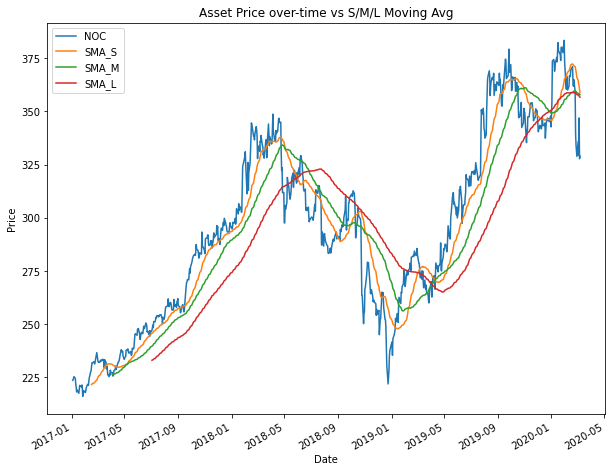

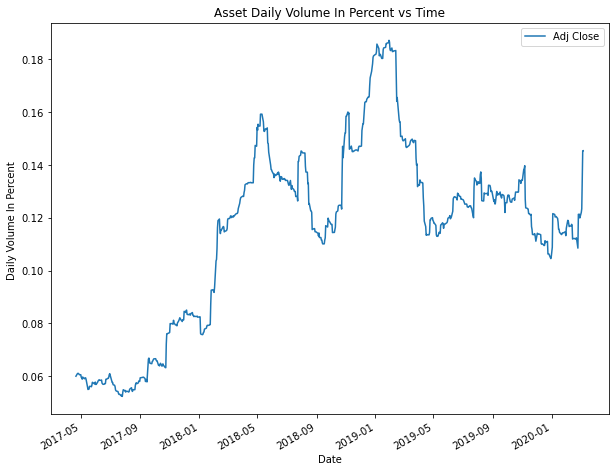

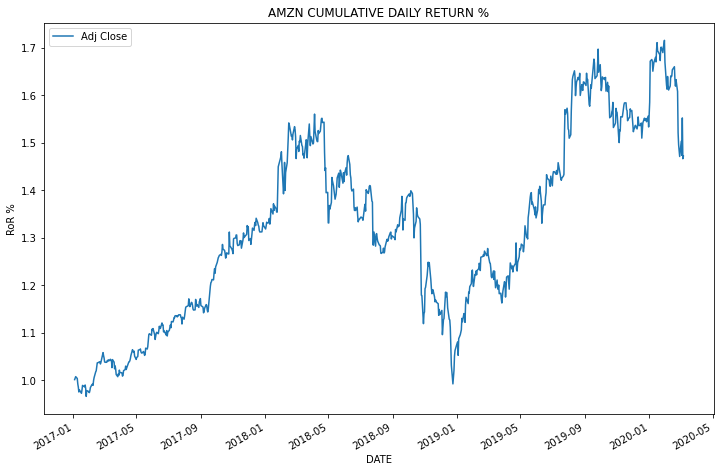

,NOC,Daily_S_RoR,Daily_Log,Total_RoR,SMA_S,SMA_M,SMA_L
Date,,,,,,,
2020-03-02,335.989990,0.021743,0.021510,1.502991,364.654430,358.559522,357.744502
2020-03-03,329.380005,-0.019673,-0.019869,1.473423,362.944578,358.224416,357.470900
2020-03-04,346.970001,0.053403,0.052026,1.552109,361.924603,358.327301,357.349775
2020-03-05,327.779999,-0.055307,-0.056896,1.466265,360.344734,358.103126,357.030584
2020-03-06,328.959991,0.003600,0.003593,1.471544,358.893246,357.896731,356.749253


In [11]:
amzn['SMA_S'] = adj_close_px.rolling(window=31).mean()
amzn['SMA_M'] = adj_close_px.rolling(window=63).mean()
amzn['SMA_L'] = adj_close_px.rolling(window=126).mean()

amzn[[ticker, 'SMA_S', 'SMA_M', 'SMA_L']].plot(figsize=(10, 8))
plt.ylabel('Price')
plt.title('Asset Price over-time vs S/M/L Moving Avg')

min_periods = 75 
vol = amzn_daily_pct_c.rolling(min_periods).std() * np.sqrt(min_periods) 
vol.plot(figsize=(10, 8))
plt.ylabel('Daily Volume In Percent ')
plt.title('Asset Daily Volume In Percent vs Time')

amzn_cum_daily_return.plot(figsize=(12,8))
plt.title('AMZN CUMULATIVE DAILY RETURN %')
plt.xlabel('DATE')
plt.ylabel('RoR %')

plt.show()
amzn.tail()

# Build df Columns for SMA & LMA

In [12]:
short_window = 30
long_window = 90
signals = pd.DataFrame(index=amzn.index)
signals['signal'] = 0.0
signals['short_mavg'] = amzn[ticker].rolling(window=short_window,
                                              min_periods=1, 
                                              center=False).mean()
signals['long_mavg'] = amzn[ticker].rolling(window=long_window, 
                                             min_periods=1, 
                                             center=False).mean()
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 
                                            1.0, 0.0) 
signals['positions'] = signals['signal'].diff()

In [13]:
signals=signals.replace({'signal': {1.0: 'Buy', 0.0: 'Sell'}})

signals['count']=signals.loc[signals.signal == 'Buy', ['count']] = 1.0
signals['count']=signals.loc[signals.signal == 'Sell', ['count']] = -1.0

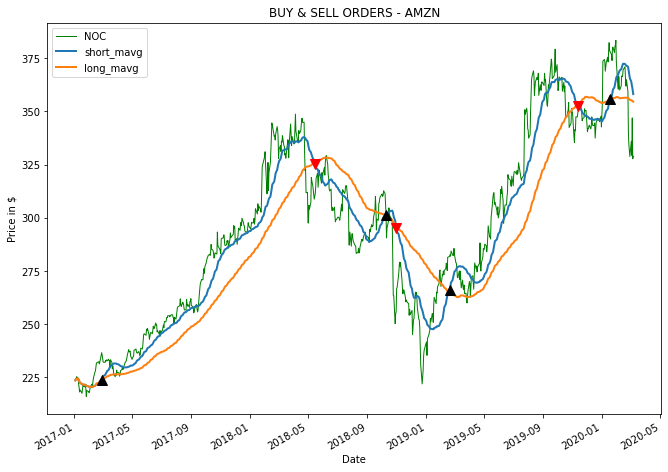

,signal,short_mavg,long_mavg,positions,count
Date,,,,,
2020-03-02,Buy,364.063397,355.338106,0.0,-1.0
2020-03-03,Buy,362.423090,355.111371,0.0,-1.0
2020-03-04,Buy,361.430226,355.071036,0.0,-1.0
2020-03-05,Buy,359.891021,354.776560,0.0,-1.0
2020-03-06,Buy,358.185898,354.626555,0.0,-1.0


In [14]:
fig = plt.figure(figsize=(11, 8))
ax1 = fig.add_subplot(111,  ylabel='Price in $')

amzn[ticker].plot(ax=ax1, color='g', lw=1)
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='k')
         
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='r')

plt.title('BUY & SELL ORDERS - AMZN')
plt.legend()
plt.show()

signals.tail()

# Evaluate Short Moving Average(SMA) vs Long Moving Average

In [15]:
short_window = 31
long_window = 63
signals = pd.DataFrame(index=amzn.index)
signals['signal'] = 0.0
signals['short_mavg'] = amzn[ticker].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_mavg'] = amzn[ticker].rolling(window=long_window, min_periods=1, center=False).mean()
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0) 
signals['positions'] = signals['signal'].diff()

## Set Portfolio 

In [16]:
initial_capital= float(50000.0)

positions = pd.DataFrame(index=signals.index).fillna(0.0)
positions['AMZN'] = 50*signals['signal']   

portfolio = positions.multiply(amzn[ticker], axis=0)
pos_diff = positions.diff()

portfolio['holdings'] = (positions.multiply(amzn[ticker],
                                            axis=0)).sum(axis=1)

portfolio['cash'] = initial_capital -(pos_diff.multiply(amzn[ticker],
                                                        axis=0)).sum(axis=1).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()

## SHARPE RATIO

In [17]:
returns = portfolio['returns']
portfolio_ror=np.sqrt(252) * (returns.mean() / returns.std())

## CONSTRUCT ORDERS

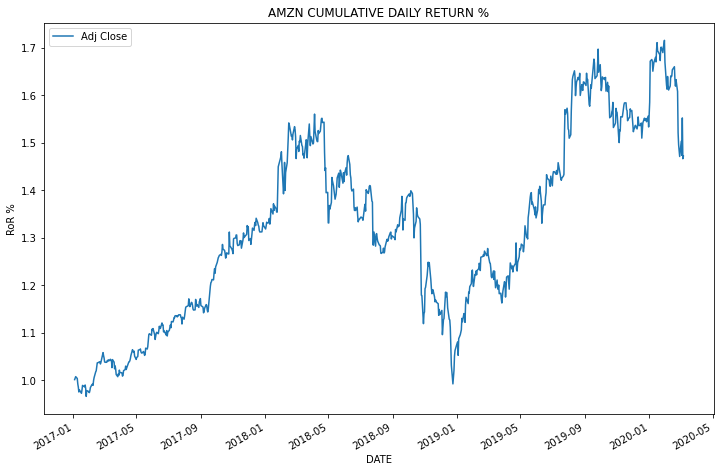

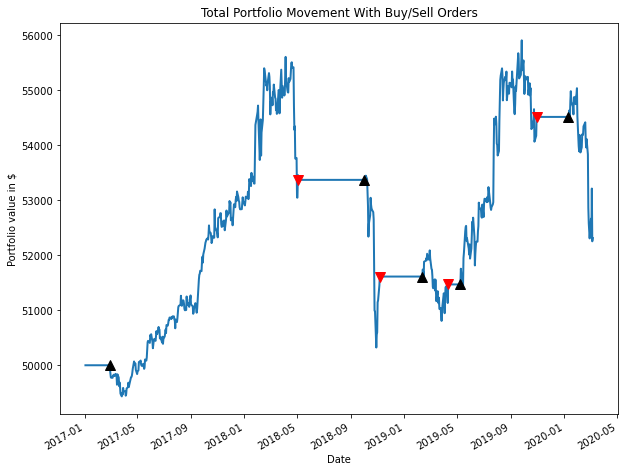

The Sharpe Ratio of NOC = 29.89%



,AMZN,holdings,cash,total,returns
Date,,,,,
2020-03-02,16799.499512,16799.499512,35865.824127,52665.323639,0.006835
2020-03-03,16469.000244,16469.000244,35865.824127,52334.824371,-0.006275
2020-03-04,17348.500061,17348.500061,35865.824127,53214.324188,0.016805
2020-03-05,16388.999939,16388.999939,35865.824127,52254.824066,-0.018031
2020-03-06,16447.999573,16447.999573,35865.824127,52313.823700,0.001129


In [18]:
amzn_cum_daily_return.plot(figsize=(12,8))
plt.title('AMZN CUMULATIVE DAILY RETURN %')
plt.xlabel('DATE')
plt.ylabel('RoR %')

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='k')

ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='r')

plt.title('Total Portfolio Movement With Buy/Sell Orders')
plt.show()

print ("The Sharpe Ratio of "+ticker+" = "+"{0:.2%}".format(portfolio_ror))
print('')
portfolio.tail()

# Demo

In [19]:
import quandl
import yfinance as yf
from yahoofinancials import YahooFinancials

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pandas_datareader as pdr

In [22]:
ticker=ticker

amzn = pdr.get_data_yahoo(ticker, 
                          start="2017-01-01",
                          end="2020-03-06")

amzn.drop(['High','Low','Open','Adj Close'],
          axis=1, inplace=True)

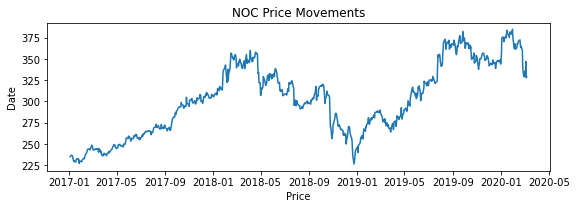

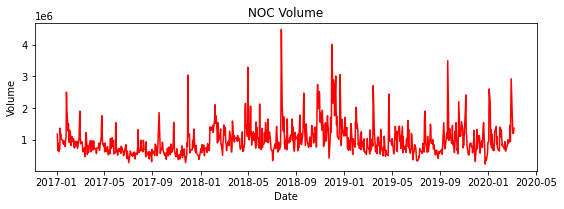

,Close,Volume
Date,,
2020-03-02,335.989990,1547000.0
2020-03-03,329.380005,1207900.0
2020-03-04,346.970001,1193700.0
2020-03-05,327.779999,1214100.0
2020-03-06,328.959991,1361200.0


In [23]:
fig = plt.figure(figsize=(9,6))
plt.subplot(211)
plt.plot(amzn['Close'])
plt.title(str(ticker)+' Price Movements')
plt.ylabel('Date')
plt.xlabel('Price')
plt.show()

fig = plt.figure(figsize=(9,6))
plt.subplot(212)
plt.plot(amzn['Volume'], color='r')
plt.title(str(ticker)+' Volume')
plt.ylabel('Volume')
plt.xlabel('Date')

plt.show()
amzn.tail()